# **WITHIN Interview Project**

*Vinh Le*

**Project Objective:**
 1. analyze the influence of market sentiment on stock price movement

 2. predict stock price trends or volatility based on sentiment.

# **1. Stock Pricing Model**

## 1.1 Import Libraries

In [544]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

## 1.2 Load Data

In [545]:
# Get NVDA stock quote
# Define the stock ticker and date range
ticker = "NVDA"
start_date = "2010-01-01"
end_date = "2025-03-01"

# Download historical data
df = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,
2010-01-04,0.423923,0.426903,0.415210,0.424381,800204000
2010-01-05,0.430113,0.434698,0.422318,0.422318,728648000
2010-01-06,0.432864,0.433781,0.425757,0.429884,649168000
2010-01-07,0.424381,0.432406,0.421171,0.430571,547792000
2010-01-08,0.425298,0.428279,0.418420,0.420942,478168000


In [546]:
# Flatten MultiIndex columns if needed
if isinstance(df.columns, pd.MultiIndex):
    df.columns = df.columns.droplevel(1)  # Drop 2nd level (ticker name)

df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,0.423923,0.426903,0.415210,0.424381,800204000
2010-01-05,0.430113,0.434698,0.422318,0.422318,728648000
2010-01-06,0.432864,0.433781,0.425757,0.429884,649168000
2010-01-07,0.424381,0.432406,0.421171,0.430571,547792000
2010-01-08,0.425298,0.428279,0.418420,0.420942,478168000


In [547]:
df = df[['High', 'Low', 'Open', 'Volume', 'Close']]

## 1.3 Exploratory Data Analysis

In [548]:
# Get the number of rows and cols in the dataset
df.shape

(3813, 5)

In [549]:
# check data type
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3813 entries, 2010-01-04 to 2025-02-28
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    3813 non-null   float64
 1   Low     3813 non-null   float64
 2   Open    3813 non-null   float64
 3   Volume  3813 non-null   int64  
 4   Close   3813 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 178.7 KB


In [550]:
# Check for Nulls
df.isna().sum()

,0
Price,
High,0
Low,0
Open,0
Volume,0
Close,0


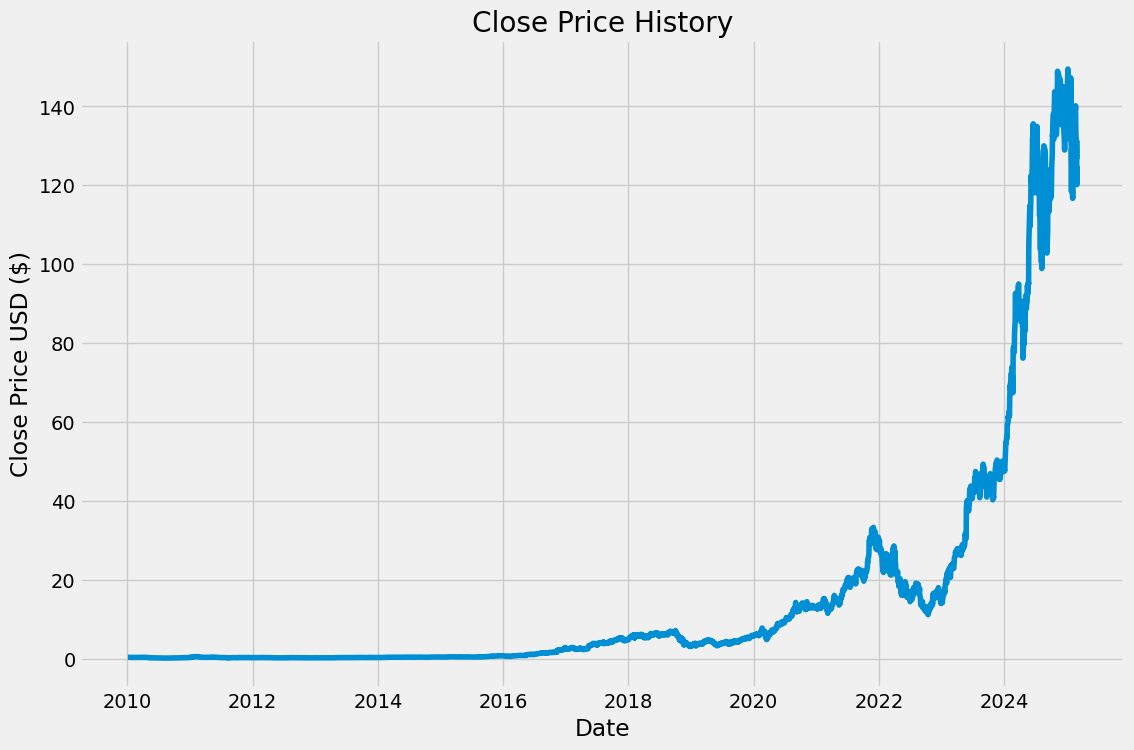

In [551]:
# Visualize the closing price history for NVDA
plt.figure(figsize=(12,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

## 1.4 Preprocessing

In [552]:
dataset = df.values

In [553]:
# Partition data
q_80 = int(len(dataset) * .8)
q_90 = int(len(dataset) * .9)


train_data = df[0:q_80]
val_data = df[q_80:q_90]
test_data = df[q_90:]

train_data.shape, val_data.shape, test_data.shape

((3050, 5), (381, 5), (382, 5))

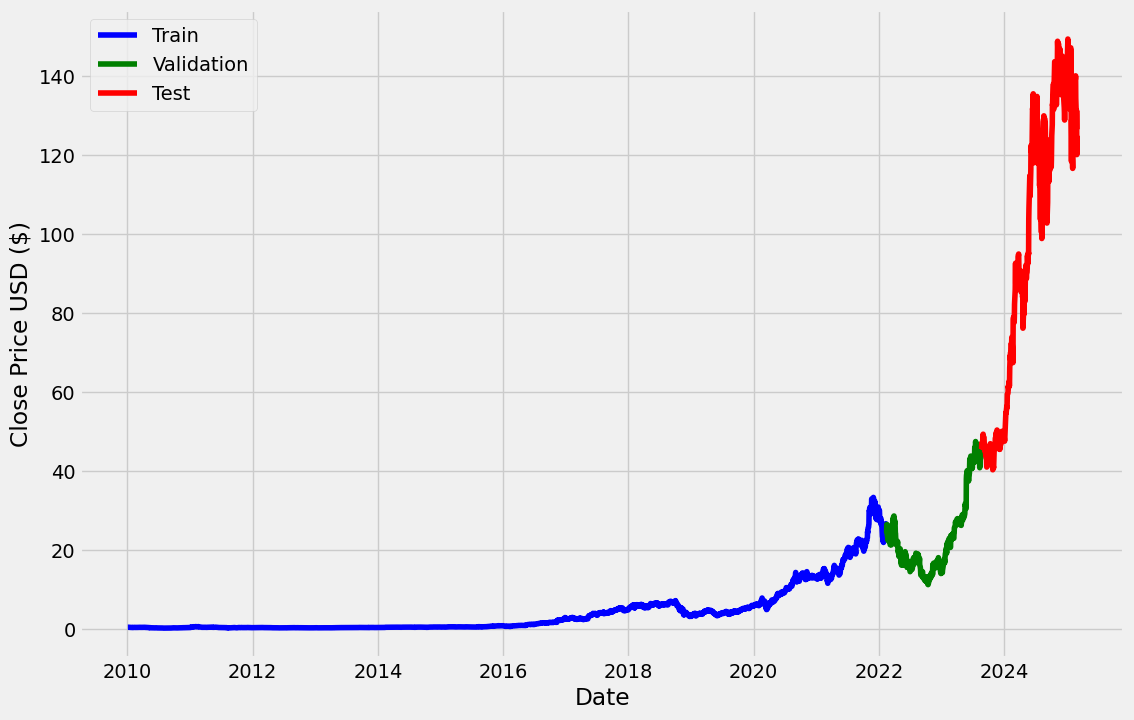

In [554]:
# Visualize the partitions
plt.figure(figsize=(12,8))
plt.plot(train_data.index, train_data['Close'], color='blue')
plt.plot(val_data.index, val_data['Close'], color='green')
plt.plot(test_data.index, test_data['Close'], color='red')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(['Train', 'Validation', 'Test'])

plt.show()

In [555]:
# Apply MinMaxScaler only on training data and transform all sets
scaler = MinMaxScaler(feature_range=(0,1))
train_scaled = scaler.fit_transform(train_data)  # Fit on train only
val_scaled = scaler.transform(val_data)  # Transform val
test_scaled = scaler.transform(test_data)  # Transform test

In [556]:
# Function to create sequences for LSTM
def create_sequences(data, timestep):
    X, y = [], []
    for i in range(timestep, len(data)):
        X.append(data[i-timestep:i, 0:data.shape[1]])  # Use past `window` days (all features)
        y.append(data[i, 4])  # Predict 'Close' price (column index 4)
    return np.array(X), np.array(y)

In [557]:
# Apply 30-day window to all features
timestep = 30
X_train, y_train = create_sequences(train_scaled, timestep)
X_val, y_val = create_sequences(val_scaled, timestep)
X_test, y_test = create_sequences(test_scaled, timestep)

In [558]:
# Reshape X for LSTM (samples, time steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [559]:
# Print final shapes
print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (3020, 30, 5) (3020,)
Val shape: (351, 30, 5) (351,)
Test shape: (352, 30, 5) (352,)


## 1.5 Build & Train LSTM model

In [560]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.LSTM(64, input_shape = (X_train.shape[1], X_train.shape[2]), return_sequences=True),
                    layers.LSTM(32, return_sequences = False),
                    layers.Dense(32, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                       │ (None, 30, 64)              │          17,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,425 (122.75 KB)

 Trainable params: 31,425 (122.75 KB)

 Non-trainable params: 0 (0.00 B)

In [561]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - loss: 0.0086 - mean_absolute_error: 0.0476 - val_loss: 0.0142 - val_mean_absolute_error: 0.0837
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0015 - mean_absolute_error: 0.0186 - val_loss: 0.0155 - val_mean_absolute_error: 0.0875
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0014 - mean_absolute_error: 0.0181 - val_loss: 0.0061 - val_mean_absolute_error: 0.0627
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0012 - mean_absolute_error: 0.0175 - val_loss: 0.0062 - val_mean_absolute_error: 0.0566
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 9.9558e-04 - mean_absolute_error: 0.0162 - val_loss: 0.0094 - val_mean_absolute_error: 0.0725
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0011 - mean_absolute_error: 0.0180 - val_loss: 0.0135 - val_mean_absolute_error: 0.0889
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0011 - mean_absolute_error: 0.0178

# 1.6 Evaluate model

95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


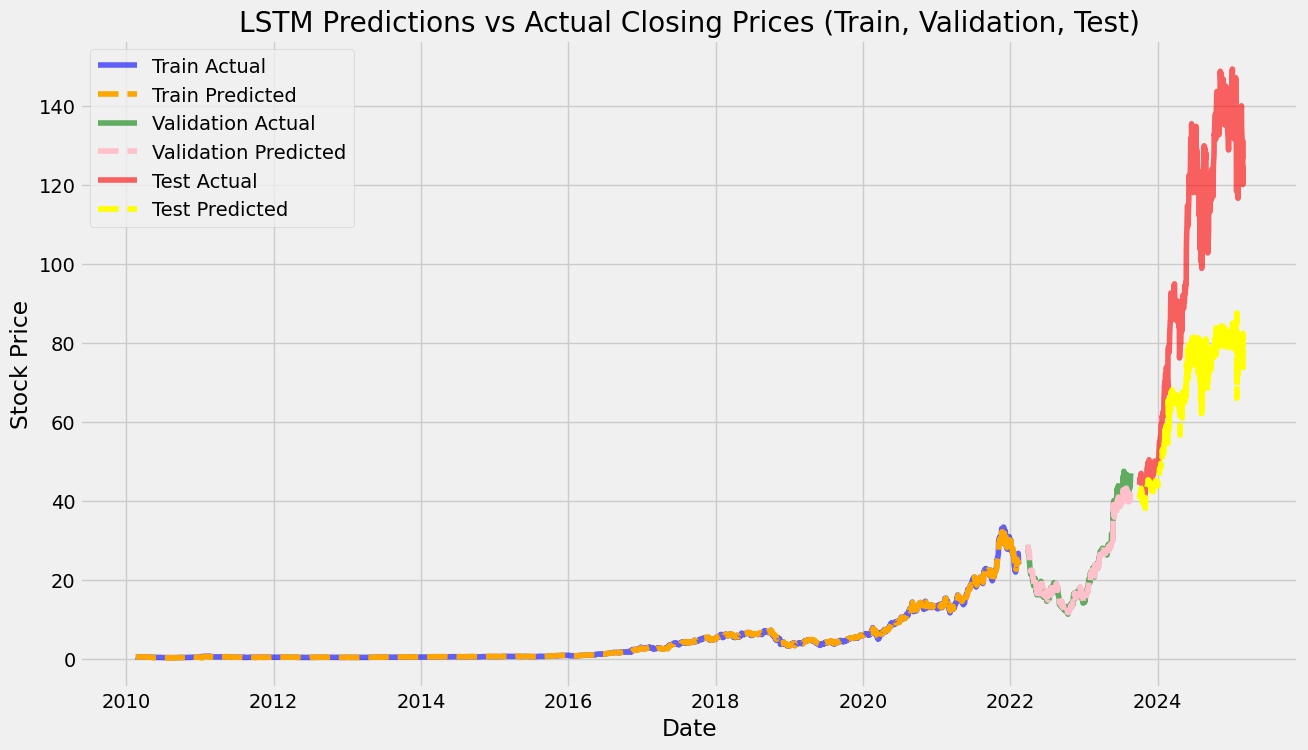

In [562]:
# Predict on all datasets
train_predictions = model.predict(X_train).flatten()
val_predictions = model.predict(X_val).flatten()
test_predictions = model.predict(X_test).flatten()

# Reshape actual values
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Create placeholder arrays for inverse transform
train_predictions_original = np.zeros((len(train_predictions), train_scaled.shape[1]))
val_predictions_original = np.zeros((len(val_predictions), val_scaled.shape[1]))
test_predictions_original = np.zeros((len(test_predictions), test_scaled.shape[1]))

y_train_original = np.zeros((len(y_train), train_scaled.shape[1]))
y_val_original = np.zeros((len(y_val), val_scaled.shape[1]))
y_test_original = np.zeros((len(y_test), test_scaled.shape[1]))

# Place actual and predicted values in the 'Close' column (index 4)
train_predictions_original[:, 4] = train_predictions
val_predictions_original[:, 4] = val_predictions
test_predictions_original[:, 4] = test_predictions

y_train_original[:, 4] = y_train.flatten()
y_val_original[:, 4] = y_val.flatten()
y_test_original[:, 4] = y_test.flatten()

# Apply inverse transform to get back original values
train_predictions_original = scaler.inverse_transform(train_predictions_original)[:, 4]
val_predictions_original = scaler.inverse_transform(val_predictions_original)[:, 4]
test_predictions_original = scaler.inverse_transform(test_predictions_original)[:, 4]

y_train_original = scaler.inverse_transform(y_train_original)[:, 4]
y_val_original = scaler.inverse_transform(y_val_original)[:, 4]
y_test_original = scaler.inverse_transform(y_test_original)[:, 4]

# Create DataFrames for plotting
train_df = pd.DataFrame({'Date': train_data.index[window:], 'Actual_Close': y_train_original, 'Predicted_Close': train_predictions_original})
val_df = pd.DataFrame({'Date': val_data.index[window:], 'Actual_Close': y_val_original, 'Predicted_Close': val_predictions_original})
test_df = pd.DataFrame({'Date': test_data.index[window:], 'Actual_Close': y_test_original, 'Predicted_Close': test_predictions_original})

# Plot all three datasets
plt.figure(figsize=(14, 8))
plt.plot(train_df['Date'], train_df['Actual_Close'], label="Train Actual", color='blue', alpha=0.6)
plt.plot(train_df['Date'], train_df['Predicted_Close'], label="Train Predicted", color='orange', linestyle="dashed")

plt.plot(val_df['Date'], val_df['Actual_Close'], label="Validation Actual", color='green', alpha=0.6)
plt.plot(val_df['Date'], val_df['Predicted_Close'], label="Validation Predicted", color='pink', linestyle="dashed")

plt.plot(test_df['Date'], test_df['Actual_Close'], label="Test Actual", color='red', alpha=0.6)
plt.plot(test_df['Date'], test_df['Predicted_Close'], label="Test Predicted", color='yellow', linestyle="dashed")

plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("LSTM Predictions vs Actual Closing Prices (Train, Validation, Test)")
plt.show()

# **2. Sentiment Analysis**

In [563]:
!pip install yfinance
!pip install nltk
!pip install vaderSentiment

## 2.1 Import Libraries

In [564]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

import requests
from datetime import datetime, timedelta

## 2.2 Load Data

In [565]:
# Retrieve News Headlines
api_key = 'eded8274774546a2a15a69184******'

url = 'https://newsapi.org/v2/everything'
params = {
    'q': 'Nvidia',
    'from': (datetime.now() - timedelta(days=28)).strftime('%Y-%m-%d'),  # Get articles from the last 30 days
    'sortBy': 'relevancy',
    'apiKey': api_key,
    'pageSize': 100,  # Maximum number of results per page
    'language': 'en'
}

# Make the request
response = requests.get(url, params=params)
data = response.json()

# Check for errors
if data['status'] != 'ok':
    raise Exception(f"NewsAPI error: {data['message']}")

# Extract articles
articles = data['articles']

# Convert to DataFrame
news_data = pd.DataFrame(articles)
news_data = news_data[['publishedAt', 'title']]
news_data.columns = ['date', 'headline']

# Display the data
news_data.head()

,date,headline
0,2025-02-19T13:57:42Z,Nvidia GeForce RTX 5070 Ti review: a cheaper R...
1,2025-02-19T21:24:22Z,Volvo’s ES90 sedan will be built with a Nvidia...
2,2025-02-10T17:54:29Z,Here’s How One OEM Is Fighting Against Nvidia ...
3,2025-02-26T01:06:27Z,Razer’s new Blade 18 offers Nvidia RTX 50-seri...
4,2025-02-28T19:10:53Z,Singapore Scheme May Have Funneled Nvidia Chip...


## 2.3 EDA

In [566]:
# Get min and max dates
min_date = news_data["date"].min()
max_date = news_data["date"].max()

print(f'from {min_date} to {max_date}')

from 2025-02-02T16:11:02Z to 2025-03-01T20:44:39Z


In [567]:
news_data.shape

(92, 2)

In [568]:
news_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      92 non-null     object
 1   headline  92 non-null     object
dtypes: object(2)
memory usage: 1.6+ KB


## 2.4 Preprocessing

In [569]:
def clean_text(text):
    """Cleans text by lowercasing, removing numbers, special characters, stopwords, and stemming."""
    if not isinstance(text, str):
        return ""  # Handle NaN or non-string values

    # Convert to lowercase
    text = text.lower()

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Remove special characters (except emojis)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenization
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words("english"))
    words = [word for word in words if word not in stop_words]

    # Apply stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Join words back to text
    return " ".join(words)


def preprocess_dataset(df):
    """Applies text cleaning to column 1 (text column) in the dataset."""
    df.iloc[:, 1] = df.iloc[:, 1].astype(str).apply(clean_text)
    return df

In [570]:
# Apply text cleaning
news_data_cleaned = preprocess_dataset(news_data)

In [571]:
news_data_cleaned.head()

,date,headline
0,2025-02-19T13:57:42Z,nvidia geforc rtx ti review cheaper rtx
1,2025-02-19T21:24:22Z,volvo es sedan built nvidia supercomput
2,2025-02-10T17:54:29Z,here one oem fight nvidia rtx scalper
3,2025-02-26T01:06:27Z,razer new blade offer nvidia rtx seri gpu dual...
4,2025-02-28T19:10:53Z,singapor scheme may funnel nvidia chip deepseek


## 2.5 Extract Sentiment from Text

In [572]:
# Perform sentiment analysis
analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(text):
    score = analyzer.polarity_scores(text)
    return score['compound']

In [573]:
news_data_cleaned['sentiment_score'] = news_data_cleaned['headline'].apply(get_sentiment_score)
news_data_cleaned["date"] = pd.to_datetime(news_data_cleaned["date"]).dt.date
news_data_cleaned.head()

,date,headline,sentiment_score
0,2025-02-19,nvidia geforc rtx ti review cheaper rtx,0.0000
1,2025-02-19,volvo es sedan built nvidia supercomput,0.0000
2,2025-02-10,here one oem fight nvidia rtx scalper,-0.3818
3,2025-02-26,razer new blade offer nvidia rtx seri gpu dual...,0.0000
4,2025-02-28,singapor scheme may funnel nvidia chip deepseek,0.0258


In [574]:
 # Filter df from 2025-02-02 to 2025-03-01
filtered_df = df.loc["2025-02-02":"2025-03-01"]

 # First DataFrame - Datetime as Index
filtered_df.index.name = "date"  # Name index

# Aggregate sentiment scores by date
aggregated_sentiment = news_data_cleaned.groupby('date')['sentiment_score'].sum().reset_index()
aggregated_sentiment["date"] = pd.to_datetime(aggregated_sentiment["date"])  # Ensure it's in datetime format

# Set "date" column as index before joining
aggregated_sentiment.set_index("date", inplace=True)

# Perform the Join
combined_data = filtered_df.join(aggregated_sentiment, how="left")  # "left" keeps all rows from df1

In [575]:
combined_data.head()

,High,Low,Open,Volume,Close,sentiment_score
date,,,,,,
2025-02-03,118.570000,113.010002,114.750000,371235700,116.660004,1.2085
2025-02-04,121.199997,116.699997,116.959999,256550000,118.650002,0.0000
2025-02-05,125.000000,120.760002,121.760002,262230800,124.830002,0.0000
2025-02-06,128.770004,125.209999,127.419998,251483600,128.679993,0.0000
2025-02-07,130.369995,125.000000,129.220001,228186300,129.839996,0.8257


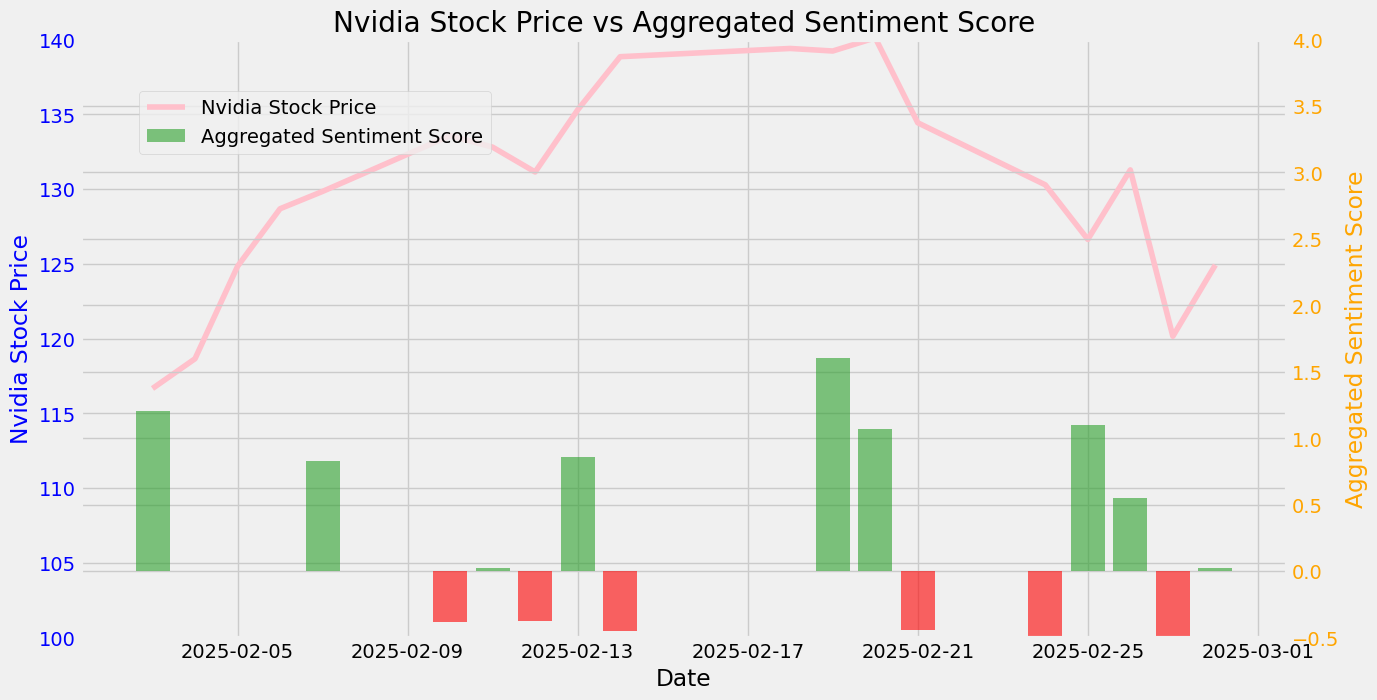

In [576]:
# Visualize the data with a secondary y-axis and bar plot for aggregated sentiment scores
fig, ax1 = plt.subplots(figsize=(14, 7))

ax1.set_xlabel('Date')
ax1.set_ylabel('Nvidia Stock Price', color='blue')
ax1.plot(combined_data.index, combined_data['Close'], label='Nvidia Stock Price', color='pink')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim(100, 140)

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Aggregated Sentiment Score', color='orange')

# Use different colors for positive and negative bar values
colors = ['tab:green' if val >= 0 else 'red' for val in combined_data['sentiment_score']]
ax2.bar(combined_data.index, combined_data['sentiment_score'], label='Aggregated Sentiment Score', color=colors, alpha=0.6)
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(-0.5, 4)  # Set the right y-axis range

fig.tight_layout()  # Otherwise, the right y-label is slightly clipped
plt.title('Nvidia Stock Price vs Aggregated Sentiment Score')
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.show()

The chart indicate there is some correlation between sentiment score and stock price movement. However, we can see on Feb 21 we have high positive sentiment yet the stock price decrease. Same also apply to Feb 25 when the price dropped even though we have mostly positive sentiments. Sentiment scores alone do not directly drive the stock price but provide contextd for understanding reactions and trends. In the following section we will retrain the LSTM pricing model along with sentiment score as an added feature to see if we can improve our orginal pricing model.

- Note we are only looking at the same time period as the news_data due to api limit.

# **3. Adding Sentiment as a Feature to the LSTM Pricing Model**

- We need more news headlines for our LSTM Pricing Model. Since we hit the API limit above, we can generate senthetic news headlines that are similar in format as the original news_data. You could use OpenAI Api as well.

## 3.1 Create new Dataset with Sentiment for training

In [577]:
# Predefined real-world style news templates
headline_templates = [
    "Nvidia's stock {trend} after {event}.",
    "{company} partners with Nvidia to {action}.",
    "AI and GPU market sees {trend} as {event}.",
    "Tech sector reacts to {event}, Nvidia included.",
    "Nvidia announces {product} at {event}.",
    "Wall Street analysts {reaction} Nvidia’s recent performance.",
    "Global chip shortage {impact} Nvidia’s supply chain.",
    "Investors {reaction} as Nvidia {action} its {product}.",
    "{company} challenges Nvidia in {market}.",
    "Regulators {action} Nvidia's {deal}.",
]

# Variables for generating diverse headlines
trends = ["soars", "plummets", "stagnates", "experiences volatility"]
events = ["earnings report", "market shift", "new product launch", "government regulations"]
companies = ["Microsoft", "AMD", "Intel", "Tesla", "Google", "Meta"]
actions = ["launch", "expand", "invest in", "merge with", "acquire"]
products = ["RTX 5090", "AI accelerator", "next-gen GPU", "cloud computing services"]
reactions = ["praise", "warn about", "remain cautious on", "predict growth for"]
impacts = ["disrupts", "stabilizes", "hinders", "boosts"]
markets = ["AI computing", "data centers", "gaming GPUs", "automotive AI"]
deals = ["acquisition of Arm", "new AI licensing agreement"]

# Function to generate realistic news headlines
def generate_realistic_news(start_date, end_date, num_samples=3813):
    additional_data = []
    date_range = np.linspace(0, (end_date - start_date).days, num_samples).astype(int)

    for days_offset in date_range:
        date = start_date + timedelta(days=int(days_offset))
        headline = random.choice(headline_templates).format(
            trend=random.choice(trends),
            event=random.choice(events),
            company=random.choice(companies),
            action=random.choice(actions),
            product=random.choice(products),
            reaction=random.choice(reactions),
            impact=random.choice(impacts),
            market=random.choice(markets),
            deal=random.choice(deals),
        )
        additional_data.append({'date': date.strftime('%Y-%m-%dT%H:%M:%SZ'), 'headline': headline})

    return pd.DataFrame(additional_data)

# Generate exactly 3,773 news samples
start_date = datetime(2010, 1, 1)
end_date = datetime(2025, 1, 30)
news_data_gen = generate_realistic_news(start_date, end_date)

In [578]:
# Apply text cleaning
news_data_gen_cleaned = preprocess_dataset(news_data_gen)

In [579]:
news_data_gen_cleaned['sentiment_score'] = news_data_gen_cleaned['headline'].apply(get_sentiment_score)
news_data_gen_cleaned["date"] = pd.to_datetime(news_data_gen_cleaned["date"]).dt.date
news_data_gen_cleaned.head()

,date,headline,sentiment_score
0,2010-01-01,investor remain cautiou nvidia acquir rtx,0.0000
1,2010-01-02,regul expand nvidia acquisit arm,0.3182
2,2010-01-03,investor prais nvidia expand nextgen gpu,0.3182
3,2010-01-05,tech sector react new product launch nvidia in...,0.0000
4,2010-01-06,tech sector react market shift nvidia includ,0.0000


In [580]:
 # First DataFrame - Datetime as Index
df.index.name = "date"  # Name index

# Aggregate sentiment scores by date
aggregated_sentiment_gen = news_data_gen_cleaned.groupby('date')['sentiment_score'].sum().reset_index()
aggregated_sentiment_gen["date"] = pd.to_datetime(aggregated_sentiment_gen["date"])  # Ensure it's in datetime format

# Set "date" column as index before joining
aggregated_sentiment_gen.set_index("date", inplace=True)

# Perform the Join
combined_data2 = df.join(aggregated_sentiment, how="left")  # "left" keeps all rows from df1

In [581]:
combined_data2.head()

,High,Low,Open,Volume,Close,sentiment_score
date,,,,,,
2010-01-04,0.426903,0.415210,0.424381,800204000,0.423923,NaN
2010-01-05,0.434698,0.422318,0.422318,728648000,0.430113,NaN
2010-01-06,0.433781,0.425757,0.429884,649168000,0.432864,NaN
2010-01-07,0.432406,0.421171,0.430571,547792000,0.424381,NaN
2010-01-08,0.428279,0.418420,0.420942,478168000,0.425298,NaN


In [582]:
combined_data2['sentiment_score'].isna().sum()

3795

In [583]:
combined_data2['sentiment_score'] = combined_data2['sentiment_score'].fillna(00)

In [584]:
combined_data2.shape

(3813, 6)

## 3.2 Preprocessing

In [585]:
# Partition data (We changed the partition slightly from the original due to small sample size).
q_80 = int(len(combined_data2) * .8)
q_90 = int(len(combined_data2) * .9)


combined_train_data = combined_data2[0:q_80]
combined_val_data = combined_data2[q_80:q_90]
combined_test_data = combined_data2[q_90:]

combined_train_data.shape, combined_val_data.shape, combined_test_data.shape

((3050, 6), (381, 6), (382, 6))

In [586]:
# Apply MinMaxScaler only on training data and transform all sets
scaler2 = MinMaxScaler(feature_range=(0,1))
combined_train_scaled = scaler2.fit_transform(combined_train_data)  # Fit on train only
combined_val_scaled = scaler2.transform(combined_val_data)  # Transform val
combined_test_scaled = scaler2.transform(combined_test_data)  # Transform test

In [587]:
# Function to create sequences for LSTM
def create_sequences(data, timestep):
    X, y = [], []
    for i in range(timestep, len(data)):
        X.append(data[i-timestep:i, 0:data.shape[1]])  # Use past `window` days (all features)
        y.append(data[i, 4])  # Predict 'Close' price (column index 4)
    return np.array(X), np.array(y)

In [588]:
# Apply 30-day window to all features
timestep = 30
combined_X_train, combined_y_train = create_sequences(combined_train_scaled, timestep)
combined_X_val, combined_y_val = create_sequences(combined_val_scaled, timestep)
combined_X_test, combined_y_test = create_sequences(combined_test_scaled, timestep)

In [589]:
# Reshape X for LSTM (samples, time steps, features)
combined_X_train = combined_X_train.reshape((combined_X_train.shape[0], combined_X_train.shape[1], combined_X_train.shape[2]))
combined_X_val = combined_X_val.reshape((combined_X_val.shape[0], combined_X_val.shape[1], combined_X_val.shape[2]))
combined_X_test = combined_X_test.reshape((combined_X_test.shape[0], combined_X_test.shape[1], combined_X_test.shape[2]))

In [590]:
# Print final shapes
print("Train shape:", combined_X_train.shape, combined_y_train.shape)
print("Val shape:", combined_X_val.shape, combined_y_val.shape)
print("Test shape:", combined_X_test.shape, combined_y_test.shape)

Train shape: (3020, 30, 6) (3020,)
Val shape: (351, 30, 6) (351,)
Test shape: (352, 30, 6) (352,)


## 3.3 Retrain model with new feature (Sentiment)

In [591]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model2 = Sequential([layers.LSTM(64, input_shape = (combined_X_train.shape[1], combined_X_train.shape[2]), return_sequences=True),
                    layers.LSTM(32, return_sequences = False),
                    layers.Dense(32, activation='relu'),
                    layers.Dropout(0.2),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])
model2.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                       │ (None, 30, 64)              │          18,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_25 (LSTM)                       │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,681 (123.75 KB)

 Trainable params: 31,681 (123.75 KB)

 Non-trainable params: 0 (0.00 B)

In [592]:
model2.fit(combined_X_train, combined_y_train, validation_data=(combined_X_val, combined_y_val), epochs=100)

Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - loss: 0.0069 - mean_absolute_error: 0.0422 - val_loss: 0.0238 - val_mean_absolute_error: 0.1139
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0019 - mean_absolute_error: 0.0203 - val_loss: 0.0083 - val_mean_absolute_error: 0.0742
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0018 - mean_absolute_error: 0.0218 - val_loss: 0.0078 - val_mean_absolute_error: 0.0632
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0011 - mean_absolute_error: 0.0167 - val_loss: 0.0057 - val_mean_absolute_error: 0.0545
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0013 - mean_absolute_error: 0.0190 - val_loss: 0.0074 - val_mean_absolute_error: 0.0598
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0015 - mean_absolute_error: 0.0196 - val_loss: 0.0098 - val_mean_absolute_error: 0.0699
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0011 - mean_absolute_error: 0.0171 - v

## 3.4 Evaluate new Model with Sentiment

95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


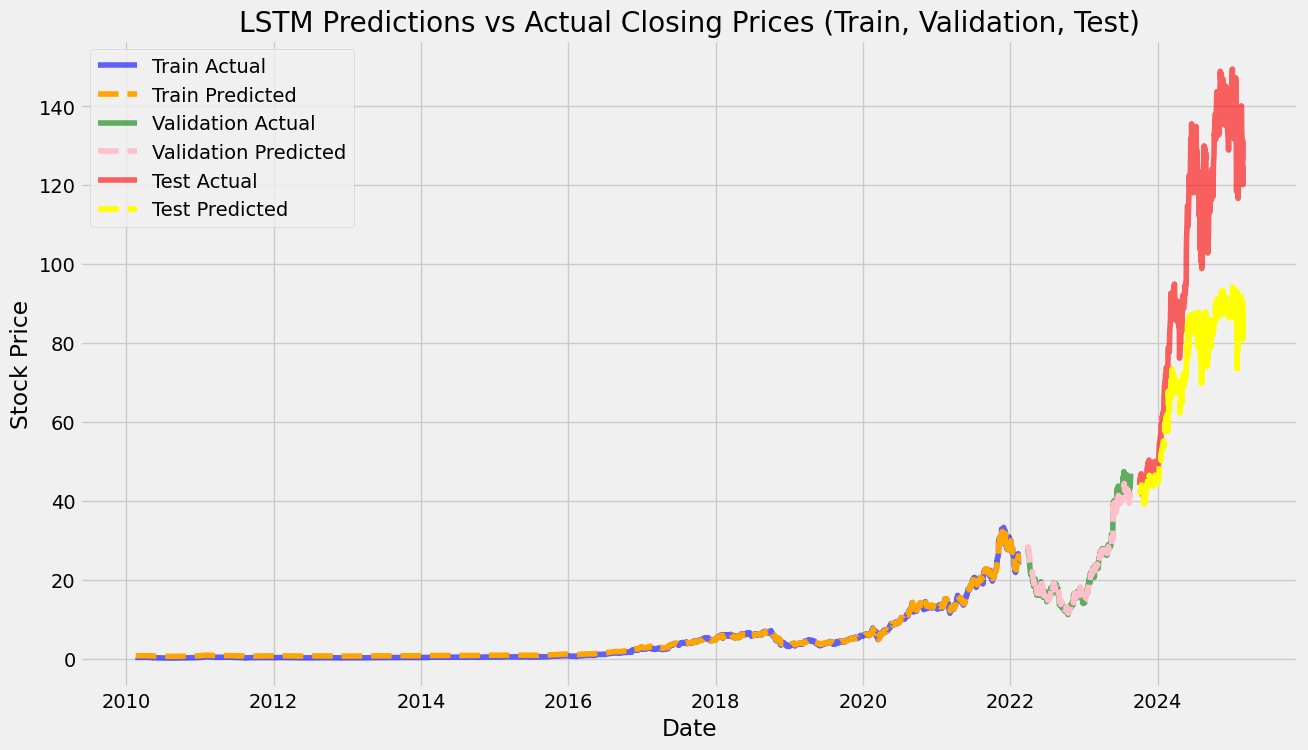

In [593]:
# Predict on all datasets
combined_train_predictions = model2.predict(combined_X_train).flatten()
combined_val_predictions = model2.predict(combined_X_val).flatten()
combined_test_predictions = model2.predict(combined_X_test).flatten()

# Reshape actual values
combined_y_train = combined_y_train.reshape(-1, 1)
combined_y_val = combined_y_val.reshape(-1, 1)
combined_y_test = combined_y_test.reshape(-1, 1)

# Create placeholder arrays for inverse transform
combined_train_predictions_original = np.zeros((len(combined_train_predictions), combined_train_scaled.shape[1]))
combined_val_predictions_original = np.zeros((len(combined_val_predictions), combined_val_scaled.shape[1]))
combined_test_predictions_original = np.zeros((len(combined_test_predictions), combined_test_scaled.shape[1]))

combined_y_train_original = np.zeros((len(combined_y_train), combined_train_scaled.shape[1]))
combined_y_val_original = np.zeros((len(combined_y_val), combined_val_scaled.shape[1]))
combined_y_test_original = np.zeros((len(combined_y_test), combined_test_scaled.shape[1]))

# Place actual and predicted values in the 'Close' column (index 4)
combined_train_predictions_original[:, 4] = combined_train_predictions
combined_val_predictions_original[:, 4] = combined_val_predictions
combined_test_predictions_original[:, 4] = combined_test_predictions

combined_y_train_original[:, 4] = combined_y_train.flatten()
combined_y_val_original[:, 4] = combined_y_val.flatten()
combined_y_test_original[:, 4] = combined_y_test.flatten()

# Apply inverse transform to get back original values
combined_train_predictions_original = scaler2.inverse_transform(combined_train_predictions_original)[:, 4]
combined_val_predictions_original = scaler2.inverse_transform(combined_val_predictions_original)[:, 4]
combined_test_predictions_original = scaler2.inverse_transform(combined_test_predictions_original)[:, 4]

combined_y_train_original = scaler2.inverse_transform(combined_y_train_original)[:, 4]
combined_y_val_original = scaler2.inverse_transform(combined_y_val_original)[:, 4]
combined_y_test_original = scaler2.inverse_transform(combined_y_test_original)[:, 4]

# Create DataFrames for plotting
combined_train_df = pd.DataFrame({'Date': combined_train_data.index[window:], 'Actual_Close': combined_y_train_original, 'Predicted_Close': combined_train_predictions_original})
combined_val_df = pd.DataFrame({'Date': combined_val_data.index[window:], 'Actual_Close': combined_y_val_original, 'Predicted_Close': combined_val_predictions_original})
combined_test_df = pd.DataFrame({'Date': combined_test_data.index[window:], 'Actual_Close': combined_y_test_original, 'Predicted_Close': combined_test_predictions_original})

# Plot all three datasets
plt.figure(figsize=(14, 8))
plt.plot(combined_train_df['Date'], combined_train_df['Actual_Close'], label="Train Actual", color='blue', alpha=0.6)
plt.plot(combined_train_df['Date'], combined_train_df['Predicted_Close'], label="Train Predicted", color='orange', linestyle="dashed")

plt.plot(combined_val_df['Date'], combined_val_df['Actual_Close'], label="Validation Actual", color='green', alpha=0.6)
plt.plot(combined_val_df['Date'], combined_val_df['Predicted_Close'], label="Validation Predicted", color='pink', linestyle="dashed")

plt.plot(combined_test_df['Date'], combined_test_df['Actual_Close'], label="Test Actual", color='red', alpha=0.6)
plt.plot(combined_test_df['Date'], combined_test_df['Predicted_Close'], label="Test Predicted", color='yellow', linestyle="dashed")

plt.legend()
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("LSTM Predictions vs Actual Closing Prices (Train, Validation, Test)")
plt.show()

# **4. Model Comparison**

In [602]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Define a function to evaluate models
def evaluate_model(y_test, test_predictions, model):
    mse = mean_squared_error(y_test, test_predictions)
    mae = mean_absolute_error(y_test, test_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, test_predictions)

    print(f"{model} Metrics:")
    print(f"MSE:  {mse:.4f}")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print("-" * 40)

In [606]:
# Compare both models
evaluate_model(y_test, test_predictions, "LSTM Model1 Without Sentiment")
evaluate_model(combined_y_test, combined_test_predictions, "LSTM Model2 With Sentiment")

LSTM Model1 Without Sentiment Metrics:
MSE:  1.3710
MAE:  0.9922
RMSE: 1.1709
R² Score: -0.2629
----------------------------------------
LSTM Model2 With Sentiment Metrics:
MSE:  1.0013
MAE:  0.8413
RMSE: 1.0006
R² Score: 0.0777
----------------------------------------


# **5. Summary**

Predicting stock prices is a very difficult task. From our analysis, we can see that sentiment can have some effects on the stock price movement. However, it alone does not provide enough information to accurately predict stock prices. There are many things to consider other than what is presented in this project.